In [15]:
import os, csv, re, logging, argparse
import categoriser
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [16]:
# Tkinter tryout
# https://datatofish.com/matplotlib-charts-tkinter-gui/

# import tkinter as tk
# from pandas import DataFrame
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# data1 = {'Country': ['US','CA','GER','UK','FR'],
#          'GDP_Per_Capita': [45000,42000,52000,49000,47000]
#         }
# df1 = DataFrame(data1,columns=['Country','GDP_Per_Capita'])


# data2 = {'Year': [1920,1930,1940,1950,1960,1970,1980,1990,2000,2010],
#          'Unemployment_Rate': [9.8,12,8,7.2,6.9,7,6.5,6.2,5.5,6.3]
#         }
# df2 = DataFrame(data2,columns=['Year','Unemployment_Rate'])


# data3 = {'Interest_Rate': [5,5.5,6,5.5,5.25,6.5,7,8,7.5,8.5],
#          'Stock_Index_Price': [1500,1520,1525,1523,1515,1540,1545,1560,1555,1565]
#         }  
# df3 = DataFrame(data3,columns=['Interest_Rate','Stock_Index_Price'])
 

# root= tk.Tk() 
  
# figure1 = plt.Figure(figsize=(6,5), dpi=100)
# ax1 = figure1.add_subplot(111)
# bar1 = FigureCanvasTkAgg(figure1, root)
# bar1.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH)
# df1 = df1[['Country','GDP_Per_Capita']].groupby('Country').sum()
# df1.plot(kind='bar', legend=True, ax=ax1)
# ax1.set_title('Country Vs. GDP Per Capita')

# root.mainloop()

In [17]:
# Argument parser
parser = argparse.ArgumentParser()

# Logger
logging.basicConfig(level=logging.WARNING)
logging.info("Replace input_path variable with the path to your chosen CSV file")

# Change file name here
input_csv ='example.csv'

# Colors to text
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

###############################################################################################
#   Reading the CSV file, converting into a data frame and outputing a CSV file with categories
###############################################################################################
dir_path = os.path.abspath('')
output_path = dir_path+r'/output.csv'
input_path  = dir_path+'/'+input_csv

# Convert the data format in the CSV to something more managable
data = pd.read_csv(input_path) 
data.info()
print()
data['Date']= pd.to_datetime(data['Date'],dayfirst=True)

data.rename(columns={'Transaction Description':'Description', 'Available Balance':'Balance'}, inplace = True)
data['Withdrawal']= pd.to_numeric(data['Withdrawal'])
data['Deposit']= pd.to_numeric(data['Deposit'])
data['Balance']= pd.to_numeric(data['Balance'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     713 non-null    object 
 1   Transaction Description  713 non-null    object 
 2   Withdrawal               713 non-null    float64
 3   Deposit                  713 non-null    float64
 4   Available Balance        713 non-null    float64
dtypes: float64(3), object(2)
memory usage: 28.0+ KB



In [18]:
###############################################################################################
#   Parsing each line in csv, searching it with Regex, then outputting a category
###############################################################################################

def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex
    """
    for key, rx in categoriser.rx_dict.items():
        for item in rx:
            match = item.search(line)
            if match:
                return key, match
    # if there are no matches
    return None, None

# Initialising some variables
output_category =[]
count = 0
total = 0

for index, row in data.iterrows():
    key, match = _parse_line(row['Description'])
    total +=1
    if key != None:
        output_category.append(key) 
        count +=1
    elif key == None:
        output_category.append(None) 

print('Total transactions processed: '+str(round(count/total*100,2)) + '%')

Total transactions processed: 100.0%


In [19]:
###############################################################################################
#   Output the categories into a seperate CSV file
###############################################################################################

output_category = pd.DataFrame(output_category, columns = ['Category'])
data = pd.concat([data, output_category], axis = 1)
data = data.sort_values(by='Date')
data.to_csv(output_path)

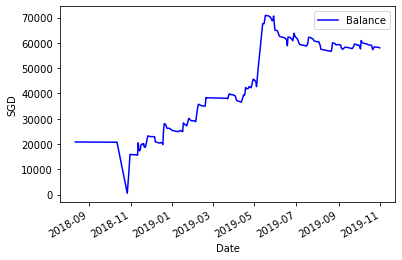

In [20]:
##############################################
# Total available balance                    #
##############################################

# Sort the entire CSV by date
def plot_whole_csv(data):
    data.groupby(data['Date']).Balance.mean().plot(kind='line',x='Month in no.',y='SGD', color='blue',ax = ax)
    ax.set_ylabel('SGD')
    ax.legend()

# or Filter the CSV by date
def filter_by_date(data):
    filtered = data
    filtered = filtered.set_index('Date')
    filtered = filtered.loc['2017':'2020']
    filtered = filtered.reset_index()

    filtered.groupby(filtered['Date']).Balance.mean().plot(kind='line',x='Month in no.',y='SGD', color='blue',ax = ax)
    ax.set_ylabel('SGD')
    ax.set_xlabel('Date')
    ax.legend()

ax = plt.subplot()
filter_by_date(data)



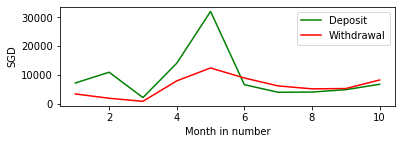

Month	 Out	 In	 Difference
1 	 3352 	 7159 	  3807 
2 	 1851 	 10914 	  9063 
3 	 787 	 2081 	  1294 
4 	 7909 	 14053 	  6143 
5 	 12405 	 32084 	  19679 
6 	 8905 	 6576 	  -2329 
7 	 6146 	 3933 	  -2212 
8 	 5124 	 4011 	  -1113 
9 	 5243 	 4843 	  -399 
10 	 8209 	 6724 	  -1484 


In [21]:
#############################################
# Compare the inflow and outflow of a month  #
#############################################

ab = data
ab = ab.set_index('Date')
ab = ab['2019']
ab = ab.reset_index()

# Uncomment if a graph is needed
ax = plt.subplot(2, 1, 2)
ab.groupby(ab.Date.dt.month).Deposit.sum().plot( color='green',ax = ax)
ab.groupby(ab.Date.dt.month).Withdrawal.sum().plot( color='red',ax = ax)
ax.set_xlabel('Month in number')
ax.set_ylabel('SGD')
ax.legend()
plt.show()

w_ = ab.groupby(ab.Date.dt.month).Withdrawal.sum()
d_ = ab.groupby(ab.Date.dt.month).Deposit.sum()

print("Month\t Out\t In\t Difference")
z=1
for x,y in zip(w_,d_):
    if int(y-x) > 0:
        print(z,'\t', int(x),'\t', int(y),'\t',f"{bcolors.OKGREEN}",int(y-x),f"{bcolors.ENDC}")
    else:
        print (z,'\t', int(x),'\t', int(y),'\t',f"{bcolors.FAIL}",int(y-x),f"{bcolors.ENDC}")
    z+=1
z=0

In [22]:
########################################################
# Flag up expenditures of more than a certain amount   #
########################################################

# Dropping categories that are not used here
g_ = ab.drop(['Deposit', 'Balance'], axis=1)
g_ = g_[g_.Withdrawal>50]
# print(g_)

Year of 2019


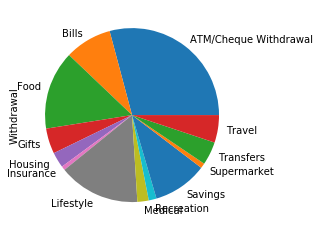

January


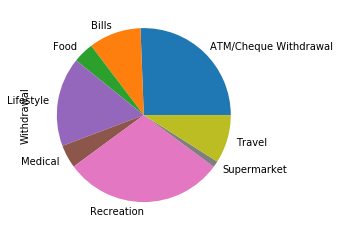

February


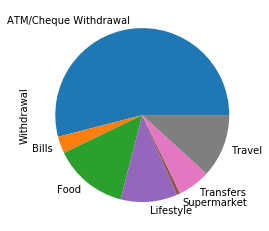

March


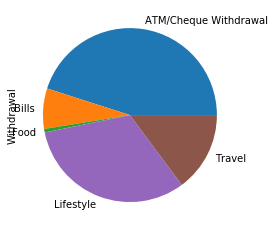

April


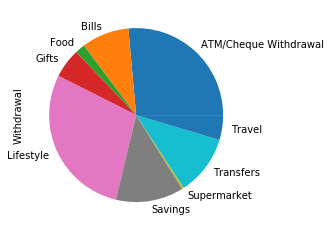

May


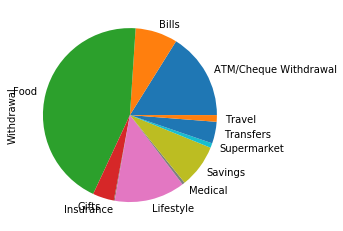

June


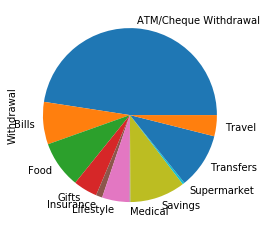

July


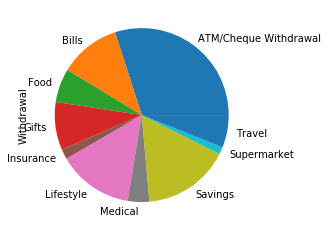

August


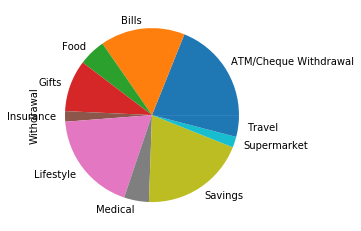

September


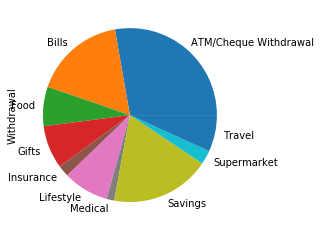

October


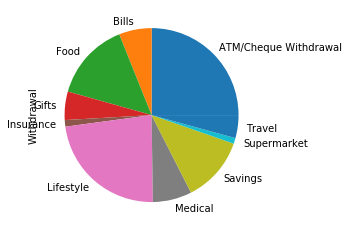

November


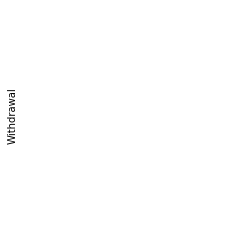

December


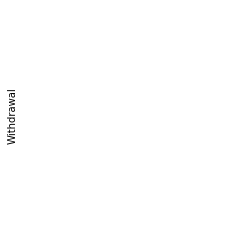

2021 Jan


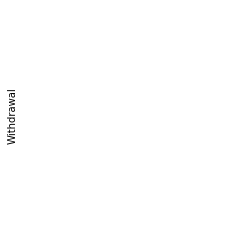

2021 Feb


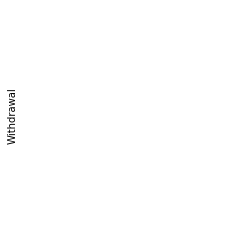

In [23]:
##############################################
# Expenditure in categories in pie a chart   #
##############################################

# ax = plt.subplot(111)
cat = data
cat = cat.set_index('Date')
cat=cat.loc['2018':'2020']

# For the whole year of 2020 pi and line chart
print("Year of 2019")
cat.groupby(cat.Category).Withdrawal.sum().plot(kind ='pie')
# print("Average spent during 2020 is ", str(cat20.Withdrawal.sum()/7.5))
plt.show()
# cat.groupby(cat.Date.dt.month).Category.mean().plot(kind='line',x='Month in no.',y='SGD', color='blue',ax = ax)

# For the breakdown by month
# cat.loc['2019-01-01':'2019-02-01'].tail(5) # Check it out here
print("January")
cat_jan = cat.loc['2019-01-01':'2019-02-01']
cat_jan.groupby(cat_jan.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("February")
cat_feb=cat.loc['2019-02-01':'2019-03-01']
cat_feb.groupby(cat_feb.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("March")
cat_march=cat.loc['2019-03-01':'2019-04-01']
cat_march.groupby(cat_march.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("April")
cat_april=cat.loc['2019-04-01':'2019-05-01']
cat_april.groupby(cat_april.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("May")
cat_may = cat.loc['2019-05-01':'2019-06-01']
cat_may.groupby(cat_may.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("June")
cat_june=cat.loc['2019-06-01':'2019-07-01']
cat_june.groupby(cat_june.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("July")
cat_july=cat.loc['2019-07-01':'2019-08-01']
cat_july.groupby(cat_july.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("August")
cat_august=cat.loc['2019-08-01':'2019-09-01']
cat_august.groupby(cat_august.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("September")
cat_september=cat.loc['2019-09-01':'2019-10-01']
cat_september.groupby(cat_september.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("October")
cat_oct=cat.loc['2019-10-01':'2019-11-01']
cat_oct.groupby(cat_oct.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("November")
cat_nov=cat.loc['2019-11-01':'2019-12-01']
cat_nov.groupby(cat_nov.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

print("December")
cat_dec=cat.loc['2019-12-01':'2021-01-01']
cat_dec.groupby(cat_dec.Category).Withdrawal.sum().plot(kind ='pie')
plt.show()

# print("2021 Jan")
# cat_dec=cat.loc['2019-01-01':'2021-02-01']
# cat_dec.groupby(cat_dec.Category).Withdrawal.sum().plot(kind ='pie')
# plt.show()

# print("2021 Feb")
# cat_dec=cat.loc['2021-02-01':'2021-03-01']
# cat_dec.groupby(cat_dec.Category).Withdrawal.sum().plot(kind ='pie')
# plt.show()